In [1]:
import numpy as np
import sys
sys.path.append('../../')
sys.path.append('../../pyfos/')
from pyfos.models.feedforward import build_feedforward
from pyfos.generic.optimizer import gd_optimizer
from pyfos.generic.regularizers import gaus_prior
from functools import partial 
from pyfos.tc.simple import  simple_tc
from pyfos.tc.cv import  cv_tc
from pyfos.hyperoptimizers.drmad_optimize import drmad_optimize
import theano
%matplotlib inline
import matplotlib.pylab as plt
import random
from pyfos.models.var_feedforward import build_var_feedforward

In [2]:
matrix = np.load('../../../data/matrix.npy')
X, Y = np.load('../../../data/linearx.npy'), np.load('../../../data/lineary.npy')
X_train = X[:100]
Y_train = Y[:100]
X_test = X[100:]
Y_test = Y[100:]
lr = theano.shared(10**(-3))
alphas = theano.shared(np.array([1.0, 1.0]))

optimizer = partial(gd_optimizer, learning_rate=lr)
model_build = partial(build_var_feedforward,  structure = [2,1], nonlinearity=lambda x:x, log_alphas=alphas, bias=False, param_pool_size=100)



In [3]:
def choicer():
    a1 = np.random.uniform(low=0.0, high=10.0)
    a2 = np.random.uniform(low=0.0, high=10.0)
    a1 = np.sqrt(10**(a1))
    a2 = np.sqrt(10**(a2))
    return np.log([a1,a2])
print choicer()    

[ 7.27779071  6.42096847]


In [22]:
import pyfos.hyperoptimizers.drmad_optimize
reload(pyfos.hyperoptimizers.drmad_optimize)
drmad_optimize = pyfos.hyperoptimizers.drmad_optimize.drmad_optimize

In [23]:
lr_ranges =   [ 10**(-3) , 0.5*10**(-3), 10**(-4), 0.5*10**(-4)]
bests = []
for _ in xrange(50):
    print 'attemp'
    
    
    lr_value = np.random.choice(lr_ranges)
    alphas_value = choicer()
    print alphas_value, lr_value

    alphas.set_value(alphas_value)

    
    #lr.set_value(lr_value)
    alphas.set_value(alphas_value)
    
    #0.5
    bests.append( drmad_optimize(partial(simple_tc, batch_size=100), model_build, optimizer, 50, 75, 10,  X_train, Y_train, 
    [alphas], lr,  lr=0.1, use_hessian=True, lr_for_learning_rate=0, verbose=-1, limits=[[-2,12.0]], lr_limits=[0,2*10**(-3)]))
    print 'final'
    print lr.eval(), alphas.eval()
    #true: 0.7, 1.5

attemp
[ 10.68088694   1.15937949] 0.0001
final
0.001 [ 5.680897    1.39952557]
attemp
[ 6.50100161  3.83947067] 0.0001
final
0.001 [ 1.54211277  1.40343996]
attemp
[ 4.6089266   5.67863278] 0.0005
final
0.001 [ 0.42189008  1.48458913]
attemp
[ 6.73762589  9.83580911] 5e-05
final
0.001 [ 1.76379747  4.83627151]
attemp
[ 3.15855945  3.21602109] 0.0005


KeyboardInterrupt: 

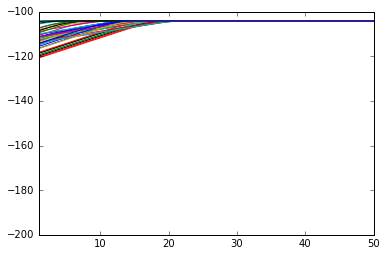

In [6]:
for b in bests:
    history = []
    for i in xrange(0, len(b.history)):
        
        best_value = max([h[1] for h in b.history[:i+1]])
        
        
        history.append(best_value)
    plt.plot(history)
plt.ylim((-200, -100))
plt.xlim((1,50))
import cPickle
with open('results_var_mad.pckl','wb') as out:
    cPickle.dump(bests, out)

In [11]:
bests2 = bests[:]

In [ ]:
import theano.tensor as T
X = T.matrix()
result = []
for b in bests:
    print b.best_values
    alphas.set_value(b.best_values[0])
    lr.set_value(b.best_values[1])
    training_procedure = cv_tc( model_build, optimizer, X_train, Y_train, validation_part=0.0, batch_size=100 )
    
    for i in xrange(10):
        training_procedure.do_train()
    
    for m in training_procedure.models:
        predict = m.predict_var(X)
        predict = theano.function([X], predict)
        
        result.append(np.mean((predict(X_test)[:,0]-Y_test)**2))
        print result[-1]
    """
    bests.append( random_optimize(partial(cv_tc, k =4,  batch_size=75), model_build, optimizer, 50, 10, X_train, Y_train,  [alphas, lr] ,
     [alpha_ranges, lr_ranges], verbose=100))
    X = T.matrix()    
    model = model_build(dataset_size=100)
    
    
    """
result = [r for r in result if not np.isnan(r)]
print np.mean(result)
print np.std(result)

In [ ]:
result = [r for r in result if not np.isnan(r)]
print np.mean(result)
print np.std(result)

In [ ]:
plt.matshow(matrix)
for i in bests:
    i = i.best_values[0]**2
    i = np.log10(i)
    
    plt.scatter(i[0]+np.random.randn(1)*0.1,i[1]+np.random.randn(1)*0.1, c='w', alpha=1.0)

In [ ]:
for i in bests:
    print np.array(i.best_values[0])**2

In [ ]:
plt.matshow(matrix)
for i in bests:
    i = i.best_values[0]**2
    i = np.log10(i)
    
    plt.scatter(i[0],i[1], c='w')